## ML Equity/Index Testing - K Neighbors

In [32]:
from backtesting.test import SMA
import pandas as pd
import yfinance as yf
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

data = yf.Ticker('FTSEMIB.MI').history(period='1y', interval="1h")[['Close', 'Open', 'High','Low']]
data

,Close,Open,High,Low
Datetime,,,,
2023-03-27 09:00:00+02:00,26092.880859,26273.570312,26328.390625,25997.990234
2023-03-27 10:00:00+02:00,26123.679688,26094.800781,26177.779297,26072.609375
2023-03-27 11:00:00+02:00,26225.519531,26123.650391,26236.390625,26123.070312
2023-03-27 12:00:00+02:00,26279.509766,26225.919922,26300.050781,26225.919922
2023-03-27 13:00:00+02:00,26251.179688,26279.140625,26309.349609,26240.439453
...,...,...,...,...
2024-03-25 17:00:00+01:00,34641.308594,34628.058594,34649.218750,34614.250000
2024-03-26 09:00:00+01:00,34718.261719,34672.351562,34756.601562,34656.558594
2024-03-26 10:00:00+01:00,34767.488281,34718.289062,34769.601562,34677.671875


In [33]:
def BBANDS(data, n_lookback, n_std):
    hlc3 = (data.High + data.Low + data.Close) / 3
    mean, std = hlc3.rolling(n_lookback).mean(), hlc3.rolling(n_lookback).std()
    upper = mean + n_std*std
    lower = mean - n_std*std
    return upper, lower


close = data.Close.values
sma10 = SMA(data.Close, 10)
sma20 = SMA(data.Close, 20)
sma50 = SMA(data.Close, 50)
sma100 = SMA(data.Close, 100)
upper, lower = BBANDS(data, 20, 2)

data['X_SMA10'] = (close - sma10) / close
data['X_SMA20'] = (close - sma20) / close
data['X_SMA50'] = (close - sma50) / close
data['X_SMA100'] = (close - sma100) / close

data['X_DELTA_SMA10'] = (sma10 - sma20) / close
data['X_DELTA_SMA20'] = (sma20 - sma50) / close
data['X_DELTA_SMA50'] = (sma50 - sma100) / close

data['X_MOM'] = data.Close.pct_change(periods=2)
data['X_BB_upper'] = (upper - close) / close
data['X_BB_lower'] = (lower - close) / close
data['X_BB_width'] = (upper - lower) / close

data['X_day'] = data.index.dayofweek
data['X_hour'] = data.index.hour

data = data.dropna().astype(float)

In [34]:
def get_X(data):
    return data.filter(like='X').values


def get_y(data):
    y = data.Close.pct_change(48).shift(-48)
    y[y.between(-.004, .004)] = 0    
    y[y > 0] = 1
    y[y < 0] = -1
    return y


def get_clean_Xy(df):
    X = get_X(df)
    y = get_y(df).values
    isnan = np.isnan(y)
    X = X[~isnan]
    y = y[~isnan]
    return X, y

Classification accuracy:  0.46938775510204084


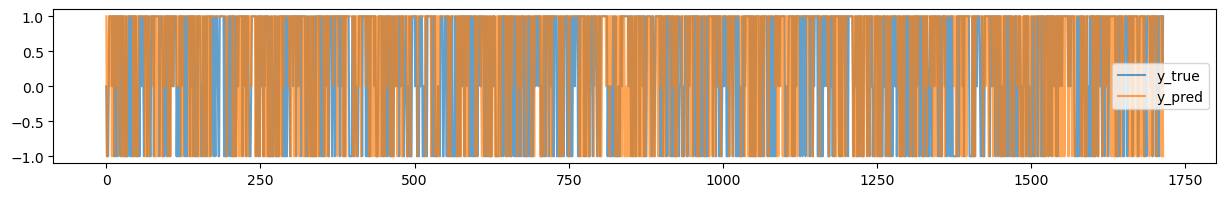

In [35]:
# Set the model

X, y = get_clean_Xy(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.8, random_state=0)

clf = KNeighborsClassifier(7)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

_ = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).plot(figsize=(15, 2), alpha=.7)
print('Classification accuracy: ', np.mean(y_test == y_pred))

In [40]:
from backtesting import Backtest, Strategy

end=len(data)


class MLTrainOnceStrategy(Strategy):
    price_delta = .01  #Customizable stop loss/take profit - currently 1%
    mysize = 0.9   #Customizable tradable size

    def init(self):        
        self.clf = KNeighborsClassifier(7)

        df = self.data.df.iloc[:end]
        X, y = get_clean_Xy(df)
        self.clf.fit(X, y)
        self.I(get_y, self.data.df, name='y_true')
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):

        high, low, close = self.data.High, self.data.Low, self.data.Close
        current_time = self.data.index[-1]

        X = get_X(self.data.df.iloc[-1:])
        forecast = self.clf.predict(X)[0]
        self.forecasts[-1] = forecast

        upper, lower = close[-1] * (1 + np.r_[1, -1]*self.price_delta)

        if forecast == 1 and not self.position.is_long:
            self.buy(size=self.mysize, tp=upper, sl=lower)
        elif forecast == -1 and not self.position.is_short:
            self.sell(size=self.mysize, tp=lower, sl=upper)

        for trade in self.trades:
            if current_time - trade.entry_time > pd.Timedelta('2 days'):
                if trade.is_long:
                    trade.sl = max(trade.sl, low)
                else:
                    trade.sl = min(trade.sl, high)


bt = Backtest(data, MLTrainOnceStrategy, cash=100000, commission=.000, margin=1)
bt.run()

Start                     2023-04-13 09:00...
End                       2024-03-26 12:00...
Duration                    348 days 04:00:00
Exposure Time [%]                   99.406664
Equity Final [$]                130541.062559
Equity Peak [$]                 130589.121152
Return [%]                          30.541063
Buy & Hold Return [%]                25.90917
Return (Ann.) [%]                   31.467246
Volatility (Ann.) [%]               11.042237
Sharpe Ratio                         2.849717
Sortino Ratio                        6.184178
Calmar Ratio                         7.003779
Max. Drawdown [%]                   -4.492895
Avg. Drawdown [%]                   -0.477492
Max. Drawdown Duration       54 days 20:00:00
Avg. Drawdown Duration        2 days 23:00:00
# Trades                                  258
Win Rate [%]                        52.325581
Best Trade [%]                       1.428485
Worst Trade [%]                     -1.311218
Avg. Trade [%]                    

In [41]:
bt.plot()

Row(id='2289', ...)

In [ ]:
# Credit by Edoardo Alberto Donolato